In [ ]:
import os
from openimages.download import download_dataset
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping
from openimages.download import download_dataset

In [ ]:
from openimages.download import download_dataset
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf

data_dir = "data"
classes = ['Flower', 'Drink', 'Car']
number_of_samples = 8000
D = 128
batch_size = 32

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

download_dataset(data_dir, classes, limit=number_of_samples)

train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for class_name in classes:
    original_class_dir = os.path.join(data_dir, class_name.lower(), 'images')
    images = [os.path.join(original_class_dir, img) for img in os.listdir(original_class_dir)]
    labels = [class_name] * len(images)

    train_imgs, val_imgs = train_test_split(images, test_size=0.2, stratify=labels, random_state=123)

    for img_path in train_imgs:
        destination = os.path.join(train_dir, class_name, os.path.basename(img_path))
        os.makedirs(os.path.dirname(destination), exist_ok=True)
        shutil.copy(img_path, destination)

    for img_path in val_imgs:
        destination = os.path.join(val_dir, class_name, os.path.basename(img_path))
        os.makedirs(os.path.dirname(destination), exist_ok=True)
        shutil.copy(img_path, destination)



100%|██████████| 8000/8000 [03:06<00:00, 42.92it/s]


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(D, D),
    batch_size=batch_size,
    shuffle=True,
    seed=123
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=val_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(D, D),
    batch_size=batch_size,
    shuffle=False
)

print("Datasets successfully prepared and loaded.")

Found 19200 files belonging to 3 classes.
Found 4800 files belonging to 3 classes.
Datasets successfully prepared and loaded.


In [ ]:
D = 128
batch_size = 32

In [ ]:
for i in train_ds.take(1):
  print(i[1]);

In [ ]:
input = tf.keras.Input(shape=(D,D,3))
x= tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same' )(input)
x= tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(x)
x= tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(x)
x= tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x= tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(x)
x= tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(x)
x= tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(x)
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512,activation='relu')(x)
x = tf.keras.layers.Dense(256,activation='relu')(x)
x = tf.keras.layers.Dense(3,activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs=x)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
epochs_number = 30

history = model.fit(train_ds, epochs=epochs_number, validation_data=test_ds)

Epoch 1/30
600/600 [==============================] - 208s 313ms/step - loss: 0.9448 - accuracy: 0.6403 - val_loss: 0.7620 - val_accuracy: 0.6648
Epoch 2/30
600/600 [==============================] - 190s 315ms/step - loss: 0.6734 - accuracy: 0.7265 - val_loss: 0.6084 - val_accuracy: 0.7583
Epoch 3/30
600/600 [==============================] - 191s 316ms/step - loss: 0.6197 - accuracy: 0.7524 - val_loss: 0.5438 - val_accuracy: 0.7885
Epoch 4/30
600/600 [==============================] - 192s 316ms/step - loss: 0.5814 - accuracy: 0.7678 - val_loss: 0.5142 - val_accuracy: 0.8135
Epoch 5/30
600/600 [==============================] - 190s 314ms/step - loss: 0.5520 - accuracy: 0.7802 - val_loss: 0.5056 - val_accuracy: 0.8067
Epoch 6/30
600/600 [==============================] - 189s 313ms/step - loss: 0.5371 - accuracy: 0.7858 - val_loss: 0.5348 - val_accuracy: 0.7948
Epoch 7/30
600/600 [==============================] - 190s 315ms/step - loss: 0.6081 - accuracy: 0.7592 - val_loss: 0.5647 -

In [ ]:
import matplotlib.pyplot as plt

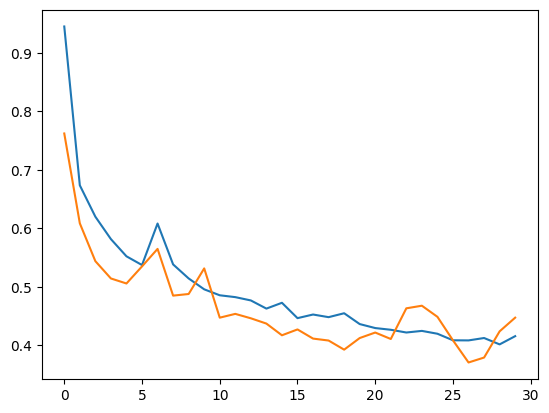

In [ ]:
epochs = [i for i in range(epochs_number)]
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.show()

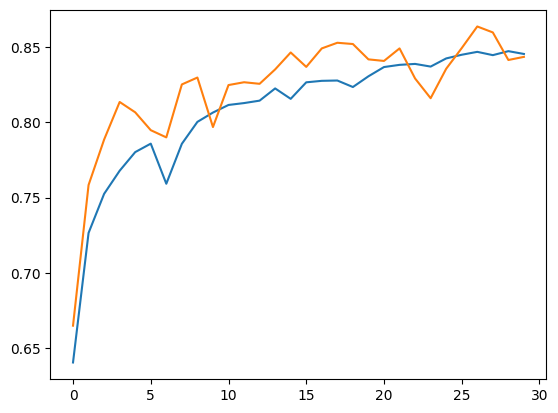

In [ ]:
plt.plot(epochs, history.history['accuracy'])
plt.plot(epochs, history.history['val_accuracy'])
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y for x, y in test_ds], axis=0)
true_labels = np.argmax(true_labels, axis=1)

150/150 [==============================] - 31s 207ms/step


In [ ]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Confusion Matrix:
[[1367  119  114]
 [ 175 1256  169]
 [  53  121 1426]]
Accuracy: 0.8435
Precision: 0.8437
Recall: 0.8435
F1 Score: 0.8430


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save('/content/drive/My Drive/my_model.h5')